In [86]:
from env.propagators.variableDebris import kineticModel
from agent.agent import PPO, DDPG, SAC
import matplotlib.pyplot as plt
import torch
dim=1
vdp = kineticModel(dim=dim, max_thrust=0.06, dt=1., device="cuda")
# agent = PPO(2*dim, dim, device=vdp.device, gamma=0.9, actor_lr=0.01, critic_lr=0.02, lmd=0.96)
agent = SAC(2*dim, dim, [1]*dim, [0.3]*dim, 
            actor_hiddens=[128]*2, critic_hiddens=[128]*2,
            gamma=0.9, device=vdp.device, 
            actor_lr=0.001, critic_lr=0.01, alpha_lr=0.001)
buffer_keys = ["obss", "next_obss", "actions", "rewards", "dones"]

In [87]:
from rich.progress import Progress
import numpy as np
n_episode = 100
# n_episode = 1
n_step = 200

Np = 1
Nd = 1
total_rewards = []
critic_loss = []

with Progress() as pbar:
    task = pbar.add_task(total=n_episode, description="episode")
    Nd = np.random.randint(1, 4)
    Nd = 2
    for episode in range(n_episode):
        sp = vdp.randomPrimalStates(Np)
        op = vdp.getObss(sp)
        td_sim = dict(zip(buffer_keys, [[] for _ in buffer_keys]))
        done_flags = torch.zeros(Np, dtype=torch.bool)
        done_steps = (n_step-1)*torch.ones(Np, dtype=torch.int32)
        Datas = []
        Rewards = torch.zeros((n_step, Np))
        # agent.init_OU_noise(Np)
        for step in range(n_step):        
            _, actions = agent.act(op)
            # actions = agent.nominal_act(op, False)
            next_sp, rewards, dones, next_op = vdp._propagate(sp, actions)
            data = (op, next_op, actions, rewards, dones)
            data = [d[~done_flags].detach().cpu().numpy() for d in data]
            Datas.append(data)

            Rewards[step,...] = rewards.detach().cpu()
            sp, op = next_sp, next_op
            done_steps[dones.cpu()&~done_flags] = step
            done_flags |= dones.cpu()
            if done_flags.all():
                break

        total_rewards.append(Rewards.sum(dim=0).mean().item())
        for _data in Datas:
            [td_sim[buffer_keys[i]].extend(_data[i]) for i in range(len(_data))]
        for key in td_sim.keys():
            # td_sim[key] = torch.stack(td_sim[key])
            td_sim[key] = np.stack(td_sim[key])
        # cl, al = agent.update(td_sim)
        cl, al, _ = agent.update(td_sim)
        critic_loss.append(cl)
        pbar.advance(task, 1)

Output()

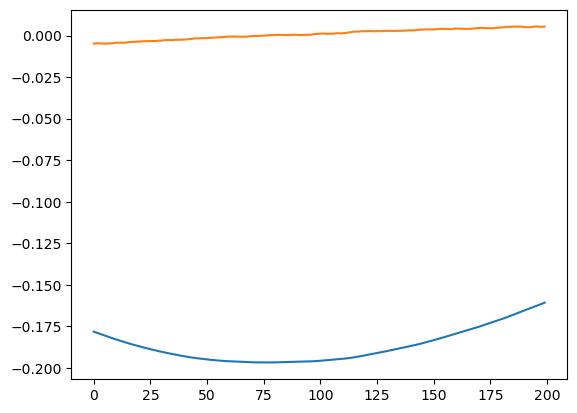

In [88]:
plt.plot(td_sim["obss"].cpu().numpy())

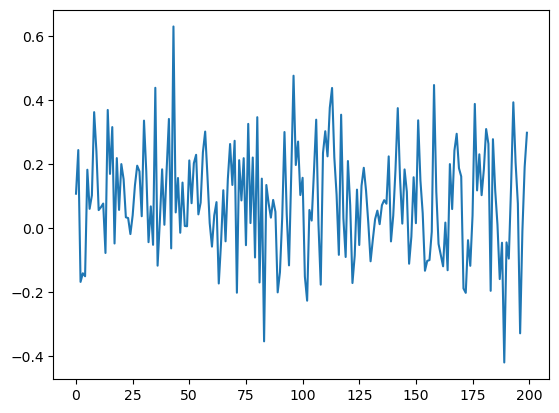

In [89]:
plt.plot(td_sim["actions"].cpu().numpy())

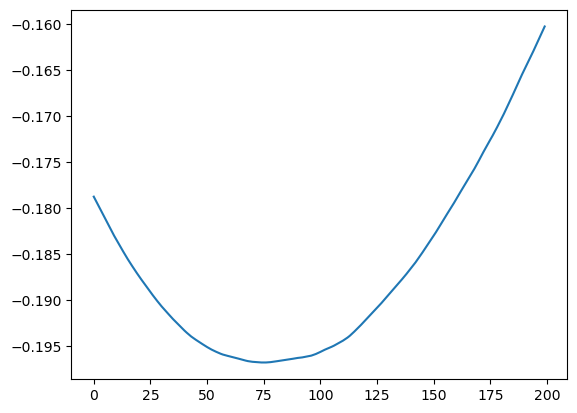

In [90]:
plt.plot(td_sim["rewards"].cpu().numpy())

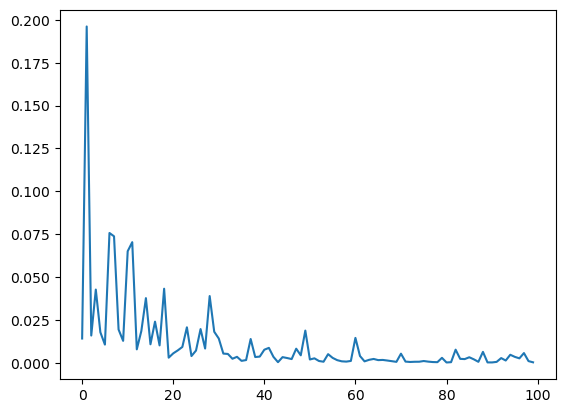

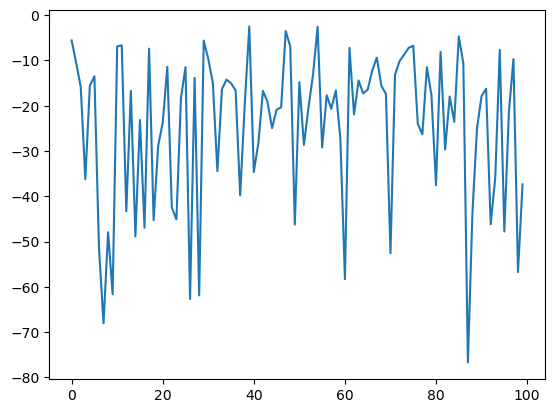

In [91]:
import matplotlib.pyplot as plt
plt.plot(critic_loss)
plt.show()
plt.plot(total_rewards)
plt.show()